# Analiza wrażliwości

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from simulation import run_simulation

%matplotlib inline

In [7]:
n_simulations = 200

In [3]:
results_normal, _ = run_simulation(n_simulations=n_simulations)

In [4]:
print("średni dochód: " + str(results_normal.mean()))
print("odchylenie z dochodu: " + str(results_normal.std()))

średni dochód: 178.487443295
odchylenie z dochodu: 104.430710935


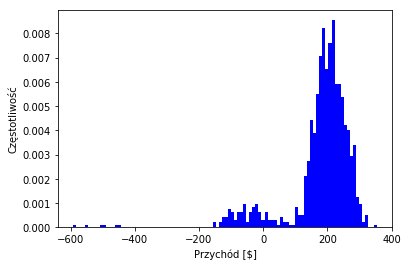

In [5]:
plt.hist(results_normal, bins=100, density = True, color = 'blue')
plt.ylabel("Częstotliwość")
plt.xlabel("Przychód [$]")
plt.show()

# Strzelaniny

In [6]:
results_faster_shootout, _ = run_simulation(n_simulations=n_simulations, p_lost_everything=0.1)
results_shootout_normal, _ = run_simulation(n_simulations=n_simulations)
results_slower_shootout, _ = run_simulation(n_simulations=n_simulations, p_lost_everything=0.02)

In [7]:
print("średnia:")
print("szybciej strzelaniny: " + str(results_faster_shootout.mean()))
print("normalne strzelaniny: " + str(results_shootout_normal.mean()))
print("wolniejsze strzelaniny: " + str(results_slower_shootout.mean()))

średnia:
szybciej strzelaniny: 682.3632748799012
normalne strzelaniny: 826.4251844514239
wolniejsze strzelaniny: 898.0621814644488


## Ile barmanów zatrudnić

In [8]:
max_male = 10
max_female = 10

male_bartenders = np.arange(0, max_male+1)
female_bartenders = np.arange(0, max_female+1)
bartender_results = np.zeros((max_male+1, max_female+1))

for i in range(bartender_results.shape[0]):
    for j in range(bartender_results.shape[1]):
        # creating unique combination of male and female bartenders
        barternders = [False] * male_bartenders[i] + [True] * female_bartenders[j]
        #running simulation
        results, _ = run_simulation(n_simulations=n_simulations, bartenders=barternders)
        
        #appending results
        bartender_results[i, j] = results.mean()

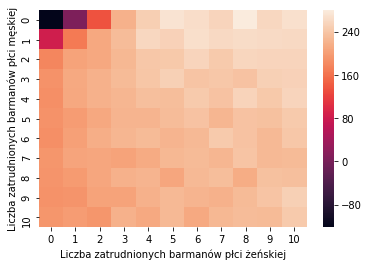

In [9]:
ax = sns.heatmap(bartender_results)
plt.ylabel("Liczba zatrudnionych barmanów płci męskiej")
plt.xlabel("Liczba zatrudnionych barmanów płci żeńskiej")
plt.show()

In [18]:
bartender_results.shape

(11, 11)

In [20]:
bartender_results[10,10]

244.53029121419101

In [22]:
np.arange(1, max_male + max_female + 1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [27]:
matrix = np.array(
         [[-2,  5,  3,  2],
          [ 9, -6,  5,  1],
          [ 3,  2,  7,  3],
          [-1,  8, -4,  8]])

diags = [matrix[::-1,:].diagonal(i) for i in range(-3,4)]
diags.extend(matrix.diagonal(i) for i in range(3,-4,-1))
print([n.tolist() for n in diags])

[[-2], [9, 5], [3, -6, 3], [-1, 2, 5, 2], [8, 7, 1], [-4, 3], [8], [2], [3, 1], [5, 5, 3], [-2, -6, 7, 8], [9, 2, -4], [3, 8], [-1]]


In [64]:
path_matrix = np.zeros((max_male + 1, max_female + 1))
optimum = 0
diags = [bartender_results[::-1,:].diagonal(i) for i in range(1-bartender_results.shape[0], bartender_results.shape[1])]
for i, x in enumerate(diags):
    i0 = min(i, path_matrix.shape[0]-1) - x.argmax()
    i1 = i-i0
    path_matrix[i0, i1] = x.max() - optimum
    optimum = x.max()

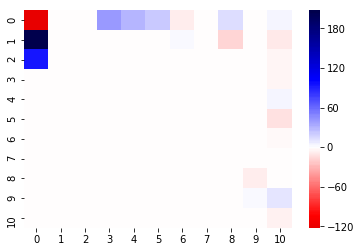

In [69]:
sns.heatmap(path_matrix, cmap = 'seismic_r', center = 0)

In [61]:
diags

[array([-122.14341158]),
 array([ 85.00040097,   5.63419213]),
 array([ 179.15095588,  168.02999183,  134.83113701]),
 array([ 189.16280002,  204.99986632,  210.81219984,  219.72654787]),
 array([ 187.28154867,  211.37008342,  209.90408987,  230.84967484,
         250.26548858]),
 array([ 190.41953736,  209.68946244,  219.27176216,  226.54530727,
         258.26943754,  272.19005366]),
 array([ 187.22363151,  199.8793499 ,  219.43264918,  228.68030024,
         242.37720346,  252.74328886,  265.21231233]),
 array([ 193.39558805,  201.81046049,  210.25874845,  224.40840313,
         239.82810529,  242.58835334,  267.20805539,  256.31682091]),
 array([ 191.49332064,  206.38611075,  216.90271853,  222.19707819,
         233.5705607 ,  251.58927955,  256.38299245,  259.96762456,
         280.12881836]),
 array([ 189.10837052,  196.92366052,  207.9349866 ,  225.09877694,
         222.25944199,  231.96685845,  238.49456514,  244.24585996,
         263.92666773,  258.59988982]),
 array([ 193.

In [60]:
path_matrix

array([[-122.14341158,    0.        ,    0.        ,  219.72654787,
         250.26548858,  272.19005366,  265.21231233,    0.        ,
         280.12881836,    0.        ,  267.98842153],
       [  85.00040097,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,  267.20805539,    0.        ,
         263.92666773,    0.        ,    0.        ],
       [ 179.15095588,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,  259.78900513,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
         255.94773436,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.       

In [53]:
df = pd.DataFrame.from_dict(bartender_results).T

In [54]:
df

,0,1,2,3,4,5,6,7,8,9,10
0,-21.564000,407.176000,474.060000,477.502000,474.082000,472.290000,479.218000,472.204000,480.194000,464.272000,470.584000
1,530.112737,812.028881,734.754648,696.750296,651.085313,624.652690,615.485415,594.665751,582.897421,566.820094,554.669742
2,1141.732325,1066.120658,935.344542,848.573509,792.714193,763.167856,720.172881,699.008224,682.372875,679.756843,652.598999
3,1535.234648,1215.188870,1080.771005,985.632810,927.524617,873.327236,821.905328,770.441813,765.244724,752.984017,708.097578
4,1603.864242,1312.015815,1169.072743,1084.762843,983.868234,956.404940,909.275863,867.056808,841.094263,799.983601,788.292056
5,1637.525949,1377.632646,1248.989102,1161.476300,1090.699024,1000.369705,960.501132,929.104864,896.194498,861.502095,827.601847
6,1642.386367,1421.231955,1299.475692,1198.657955,1109.312908,1048.433641,1032.185024,975.914018,938.654048,933.730774,884.186220
7,1630.730361,1446.588642,1332.971210,1242.761484,1166.475216,1090.713092,1072.536146,1020.097568,1007.786149,957.620048,930.269203
8,1635.011429,1478.339743,1357.838486,1279.655674,1207.667651,1168.739423,1102.556250,1056.803360,1036.593382,990.871852,972.898049
9,1616.871189,1490.772754,1382.844488,1295.182748,1247.560271,1192.504128,1160.124299,1103.126052,1081.556007,1048.594334,1014.478961


In [56]:
df.loc[:,0] / df.loc[:,2]

0    -0.045488
1     0.721483
2     1.220654
3     1.420499
4     1.371911
5     1.311081
6     1.263884
7     1.223380
8     1.204128
9     1.169236
10    1.149102
dtype: float64

## Jaka strategia cenowa

In [15]:
results_expensive, _ = run_simulation(n_simulations=n_simulations, drink_price=4, patience_threshold=10)
results_cheap, _ = run_simulation(n_simulations=n_simulations)
results_super_cheap, _ = run_simulation(
    n_simulations=n_simulations,
    drink_price=1,
    patience_threshold=20,
    customer_lambda=10)

In [16]:
print("średnia:")
print("droższe drinki: " + str(results_expensive.mean()))
print("tańsze drinki: " + str(results_cheap.mean()))
print("super tanie drinki: " + str(results_super_cheap.mean()))

print("\nodchylenie:")
print("droższe drinki: " + str(results_expensive.std()))
print("tańsze drinki: " + str(results_cheap.std()))
print("super tanie drinki: " + str(results_super_cheap.std()))

średnia:
droższe drinki: 1296.2453976240242
tańsze drinki: 815.181824982579
super tanie drinki: 739.9352499782015

odchylenie:
droższe drinki: 450.5902907357908
tańsze drinki: 291.86513282198035
super tanie drinki: 324.1916995683491


<Figure size 1440x720 with 0 Axes>

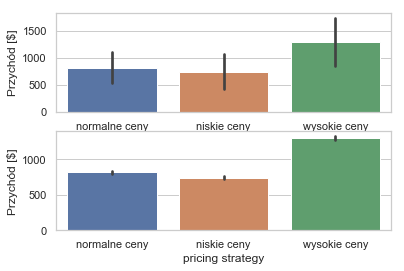

In [60]:
plt.figure(figsize=(20,10))
f, axes = plt.subplots(2, 1)
sns.set(style="whitegrid")
df_to_plot = pd.DataFrame(
    {
        "pricing strategy": 
            ["normalne ceny"] * n_simulations + 
            ["niskie ceny"] * n_simulations + 
            ["wysokie ceny"] * n_simulations,
        "Przychód [$]": np.concatenate((results_cheap, results_super_cheap, results_expensive), axis=0)
    }
)
ax = sns.barplot(x="pricing strategy", y="Przychód [$]", data=df_to_plot, ci="sd", ax=axes[0]) # standard diviation
ax = sns.barplot(x="pricing strategy", y="Przychód [$]", data=df_to_plot, ci=95, ax=axes[1]) # some bootstrap :D

<Figure size 1440x720 with 0 Axes>

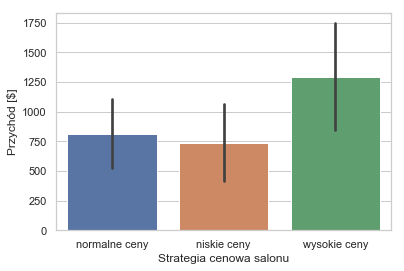

In [71]:
plt.figure(figsize=(20,10))
f, axes = plt.subplots(1, 1)
sns.set(style="whitegrid")
df_to_plot = pd.DataFrame(
    {
        "Strategia cenowa salonu": 
            ["normalne ceny"] * n_simulations + 
            ["niskie ceny"] * n_simulations + 
            ["wysokie ceny"] * n_simulations,
        "Przychód [$]": np.concatenate((results_cheap, results_super_cheap, results_expensive), axis=0)
    }
)
ax = sns.barplot(x="Strategia cenowa salonu", y="Przychód [$]", data=df_to_plot, ci="sd")
plt.show()


## Zatrudnianie ładniejszych kelnerek

In [13]:
results_normal, _ = run_simulation(n_simulations=n_simulations)
results_beautiful, _ = run_simulation(n_simulations=n_simulations, flirt_time=25, avg_tip=10)

<Figure size 1440x720 with 0 Axes>

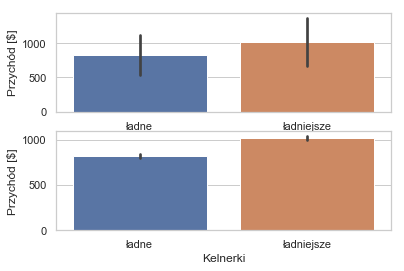

In [59]:
plt.figure(figsize=(20,10))
f, axes = plt.subplots(2, 1)
sns.set(style="whitegrid")
df_to_plot = pd.DataFrame(
    {
        "Kelnerki": 
            ["ładne"] * n_simulations + ["ładniejsze"] * n_simulations,
        "Przychód [$]": np.concatenate((results_normal, results_beautiful), axis=0)
    }
)
ax = sns.barplot(x="Kelnerki", y="Przychód [$]", data=df_to_plot, ci="sd", ax=axes[0]) # standard diviation
ax = sns.barplot(x="Kelnerki", y="Przychód [$]", data=df_to_plot, ci=95, ax=axes[1]) # some bootstrap :D

In [61]:
print("średni przychód ładna: " + str(results_normal.mean()))
print("średni przychód ładniejsza: " + str(results_beautiful.mean()))

print("odchylenie ładna: " + str(results_normal.std()))
print("odchylenie ładniejsza: " + str(results_beautiful.std()))

średni przychód ładna: 822.5380950364438
średni przychód ładniejsza: 1020.4776838776445
odchylenie ładna: 293.08143631290835
odchylenie ładniejsza: 353.74086946152806


## Zajęcie w kolejce

In [8]:
import tqdm
patience_results = np.zeros(11)

for patience in tqdm.tqdm(range(len(patience_results))):
    results, _ = run_simulation(n_simulations=int(n_simulations), patience_threshold=patience)
    patience_results[patience] = results.mean()

100%|██████████████████████████████████████████| 11/11 [01:23<00:00,  9.58s/it]


In [9]:
patience_results

array([435.6016491 , 475.89328599, 504.7563149 , 546.02563837,
       593.28752243, 815.7701825 , 826.60477956, 809.80233008,
       822.65255175, 833.8924749 , 820.31587068])

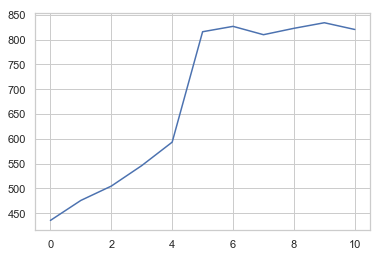

In [10]:
sns.set(style="whitegrid")
plt.plot(patience_results)
plt.show()

## Lepszy wystrój, więcej klientów, wyższa strata

In [11]:
import tqdm
decor_results = np.zeros(20)

for decor in tqdm.tqdm(range(1, len(decor_results))):
    results, _ = run_simulation(
        n_simulations=int(n_simulations/10), 
        shootout_loss=5*decor, 
        customer_lambda=(2*decor+5))
    decor_results[decor] = results.mean()

100%|██████████████████████████████████████████| 19/19 [01:04<00:00,  1.59it/s]


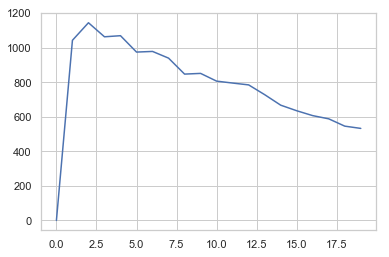

In [12]:
sns.set(style="whitegrid")
plt.plot(decor_results)
plt.show()

# Większe stoły do pokera

In [67]:
results_normal, _ = run_simulation(n_simulations=n_simulations)
results_1, _ = run_simulation(n_simulations=n_simulations, poker_table_size=6, poker_length=15)
results_2, _ = run_simulation(n_simulations=n_simulations, poker_table_size=7, poker_length=20)
results_3, _ = run_simulation(n_simulations=n_simulations, poker_table_size=8, poker_length=25)

<Figure size 1440x720 with 0 Axes>

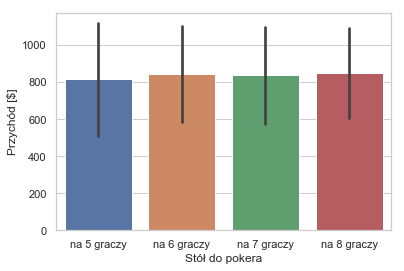

In [68]:
plt.figure(figsize=(20,10))
f, axes = plt.subplots(1, 1)
sns.set(style="whitegrid")
df_to_plot = pd.DataFrame(
    {
        "Stół do pokera": 
            ["na 5 graczy"] * n_simulations + ["na 6 graczy"] * n_simulations + ["na 7 graczy"] * n_simulations + ["na 8 graczy"] * n_simulations,
        "Przychód [$]": np.concatenate((results_normal, results_1, results_2, results_3), axis=0)
    }
)
ax = sns.barplot(x="Stół do pokera", y="Przychód [$]", data=df_to_plot, ci="sd") 
plt.show()

In [69]:
print("średni przychód normal: " + str(results_normal.mean()))
print("średni przychód 1: " + str(results_1.mean()))
print("średni przychód 2: " + str(results_2.mean()))
print("średni przychód 3: " + str(results_3.mean()))

print("odchylenie normal: " + str(results_normal.std()))
print("odchylenie przychód 1: " + str(results_1.std()))
print("odchylenie przychód 2: " + str(results_2.std()))
print("odchylenie przychód 3: " + str(results_3.std()))

średni przychód normal: 814.2297915075026
średni przychód 1: 844.9545849162033
średni przychód 2: 836.1973763444387
średni przychód 3: 848.9268616365201
odchylenie normal: 303.81926733468526
odchylenie przychód 1: 260.0646345569441
odchylenie przychód 2: 260.6094148670927
odchylenie przychód 3: 241.09387100192473
